# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import general libraries 
from sqlalchemy import create_engine 
import numpy as np
import pandas as pd 
import string 
import re 
import nltk
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# scikit-learn libraries 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score,  make_scorer


# to save and load scikit-learn models
import pickle 

# plotting function
import matplotlib.pyplot as plt

# custom scoring function for multioutput classifier with imbalaced dataset 
prec_score_multiclass =  make_scorer(precision_score, average='weighted') 


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # download for lemmatization

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# In order to process the data we adapt code from the following web site: 
# https://blog.chapagain.com.np/python-nltk-twitter-sentiment-analysis-natural-language-processing-nlp/


from nltk.corpus import stopwords 
stopwords_english = stopwords.words('english')
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer


# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
 
# all emoticons (happy + sad)
emoticons = emoticons_happy.union(emoticons_sad)

In [3]:
def load_data():    
    """ Returns the data for training the disaster response pipeline. 
    
    Returns:
        X (numpy array): Tweets.  
        Y (numpy array): Categories associated to each tweet.
        categories (list): list of categories. 
    
    """
    
    
    engine = create_engine('sqlite:///DisasterResponse.db')
    df = pd.read_sql_table('Message', engine)
    X = df.message.values    
    Y = df.iloc[:, 4:]     
        
    categories = Y.columns
    categories = categories.tolist()
    
    Y = Y.values 
    
    return X, Y, categories 

X, Y, categories = load_data()


### 2. Write a tokenization function to process your text data

In [4]:


def tokenize(text):
    """ Returns a tokenized tweet. This functions do the following taks: 
        Remove retweet text "RT"
        Remove hyperlinks
        Remove hashtags (only the hashtag # and not the word)
        Remove stop words like a, and, the, is, are, etc.
        Remove emoticons like :), :D, :(, :-), etc.
        Remove punctuation like full-stop, comma, exclamation sign, etc.
        Apply lemmatization first and then stemming.
        
    Parameters: text (string): tweet data.     

    Returns: words (list of strings): tokenized tweet.    
    
    """    
    
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', text)
 
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    
    tweet_tokens = tokenizer.tokenize(tweet)
    
    # removing words that are common
    words = [w for w in tweet_tokens if w not in stopwords.words("english")]
    
    # removing emoticons 
    words = [w for w in words if w not in emoticons]
        
    # removing punctuations 
    words = [ re.sub(r'[^\w\s]', '', w) for w in words]
    
    # removing words that are equal to ''
    words = [ w for w in words if w != '']
    
    # removing words that has numbers 
    words = [w for w in words if w.isalpha() ]

    # removing words that has length equal to 1 
    words = [w for w in words if len(w) > 1 ]
            
    # we apply lemmatization first and then stemming
    # we follow a suggestion from a video that is part of 
    # Data Scientist Nanodegree from Udacity
    words = [WordNetLemmatizer().lemmatize(w) for w in words ]
    words = [WordNetLemmatizer().lemmatize(w, pos='v') for w in words ]
    
    words = [PorterStemmer().stem(w) for w in words ]
    
    
    return words 

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [5]:
pipeline = Pipeline([
    ('vec', CountVectorizer(tokenizer=tokenize)), 
    ('tfidf', TfidfTransformer()), 
    ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=25, class_weight='balanced', n_jobs=-1)))     
 ])


### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)


In [7]:

pipeline.fit(X_train, Y_train);

/home/ubuntu/my_project/my_project_env/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ubuntu/my_project/my_project_env/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ubuntu/my_project/my_project_env/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ubuntu/my_project/my_project_env/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [8]:
Y_pred = pipeline.predict(X_test)

In [9]:
for col in range(Y_pred.shape[1]):
    
    print("Category: {}".format(categories[col]))
    print(classification_report(Y_test[:, col], Y_pred[:, col]))    

Category: related
              precision    recall  f1-score   support

           0       0.65      0.51      0.57      1560
           1       0.86      0.91      0.88      4968

    accuracy                           0.82      6528
   macro avg       0.75      0.71      0.73      6528
weighted avg       0.81      0.82      0.81      6528

Category: request
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      5451
           1       0.80      0.48      0.60      1077

    accuracy                           0.89      6528
   macro avg       0.85      0.73      0.77      6528
weighted avg       0.89      0.89      0.88      6528

Category: offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6504
           1       0.00      0.00      0.00        24

    accuracy                           1.00      6528
   macro avg       0.50      0.50      0.50      6528
weighted avg       0.9

/home/ubuntu/my_project/my_project_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.95      1.00      0.98      6227
           1       0.50      0.02      0.04       301

    accuracy                           0.95      6528
   macro avg       0.73      0.51      0.51      6528
weighted avg       0.93      0.95      0.93      6528

Category: buildings
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      6182
           1       0.68      0.05      0.10       346

    accuracy                           0.95      6528
   macro avg       0.81      0.53      0.54      6528
weighted avg       0.94      0.95      0.93      6528

Category: electricity
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6394
           1       0.59      0.07      0.13       134

    accuracy                           0.98      6528
   macro avg       0.78      0.54      0.56      6528
weighted avg       0.97      0.9

In [10]:
def get_precision_recall(Y_test, Y_pred):
    
    """ Returns precisions and recalls across the categories.
    
    Parameters: 
        Y_test (numpy array): Y observed 
        Y_pred (numpy array): Y predicted 
        
    Returns: 
        precisions (list): list containing the values of precision in each category.
        recalls (list): list containing the values of recalls in each category.
    
    """
    
    precisions = []
    recalls = [] 
                
    for col in range(Y_pred.shape[1]):
        out = classification_report(Y_test[:, col],  Y_pred[:, col], output_dict=True)
        
        if '1' in out.keys():
            precisions.append(out['1']['precision'])
            recalls.append(out['1']['recall'])
        
    return precisions, recalls

In [11]:
def plot_metric(metrics, type_metric):

    """ Plot a histogram of the metrics accross the categories.
    
    Parameters: 
        metrics (list): a list of metrics
        type_metric (string): precision or recall
        
    Returns: Nothing
    
    """
    
    if type_metric == 'precision':
        plt.hist(metrics, 10, density=True, facecolor='g', alpha=0.75)
        plt.xlabel('Precision')
        plt.ylabel('Relative frequency')
        plt.title('Histogram of precisions')
    
    elif type_metric == 'recall':
        plt.hist(metrics, 10, density=True, facecolor='g', alpha=0.75)
        plt.xlabel('Recall')
        plt.ylabel('Relative frequency')
        plt.title('Histogram of recalls')
    
    else:
        raise ValueError("The argument type_metric must be precision or recall")
            

In [12]:
precisions, recalls = get_precision_recall(Y_test, Y_pred)

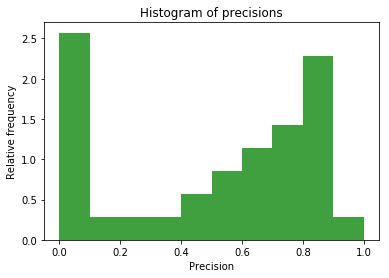

In [13]:
plot_metric(precisions, 'precision')

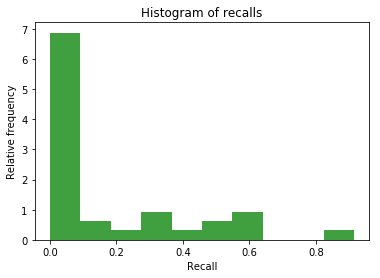

In [14]:
plot_metric(recalls, 'recall')

### 6. Improve your model
Use grid search to find better parameters. Below the default parameters are shown.

In [15]:
# good resource 
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# to get the list of hyperparameters
# pipeline.get_params().keys()

In [16]:
# Number of trees in random forest
n_estimators = [10 , 50, 100]
# Maximum number of levels in tree
max_depth = [2,  10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [17]:
parameters = {        
    'clf__estimator__n_estimators': n_estimators,
    'clf__estimator__max_depth': max_depth,
    'clf__estimator__bootstrap': bootstrap            
}

cv = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring=prec_score_multiclass,  cv=3,   verbose=25, n_jobs=-1)

In [18]:
cv.fit(X_train, Y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  3

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                             

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [19]:
Y_pred = cv.predict(X_test)

In [20]:
for col in range(Y_pred.shape[1]):
    
    print("Category: {}".format(categories[col]))
    print(classification_report(Y_test[:, col], Y_pred[:, col]))


Category: related
              precision    recall  f1-score   support

           0       0.48      0.82      0.61      1560
           1       0.93      0.73      0.81      4968

    accuracy                           0.75      6528
   macro avg       0.71      0.77      0.71      6528
weighted avg       0.82      0.75      0.77      6528

Category: request
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      5451
           1       0.56      0.73      0.63      1077

    accuracy                           0.86      6528
   macro avg       0.75      0.81      0.77      6528
weighted avg       0.88      0.86      0.87      6528

Category: offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6504
           1       0.00      0.00      0.00        24

    accuracy                           0.99      6528
   macro avg       0.50      0.50      0.50      6528
weighted avg       0.9

/home/ubuntu/my_project/my_project_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
precisions, recalls = get_precision_recall(Y_test, Y_pred)

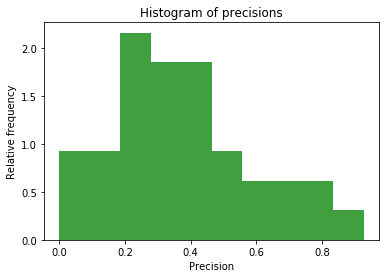

In [22]:
plot_metric(precisions, 'precision')

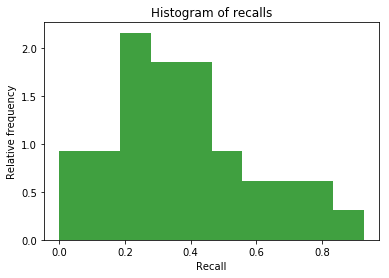

In [23]:
plot_metric(precisions, 'recall')

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

We add the lenght of the text as a feature and we use a feature union in the pipeline.

In [25]:
class LengthExtractor(BaseEstimator, TransformerMixin):
    
    """ This class is a transformer that will be used in a Pipeline to extract the lenght of the tweets.
    
    """
        
    def fit(self, X, y=None):
        """ Fit method 
    
        Parameters:
            self: the self object. 
            X : input variables
            y : output variables
    
        Returns: 
            self: the self object. 
    """         
        
        return self

    def transform(self, X):
        """ Transform method 
    
        Parameters:
            self: the self object. 
            X : input variables
    
        Returns: 
            A 2d-numpy array containing the length of the tweets. 
    """                 
        
        return pd.Series(X).apply(lambda x: len(x)).values[:, None]
    

In [26]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)), 
            ('tfidf', TfidfTransformer())            
        ])), 
        
        ('text_length',  LengthExtractor()) 
                
        ])), 
    
        ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=25, class_weight='balanced', n_jobs=-1)))     
    ])
    

In [27]:
# Number of trees in random forest
n_estimators = [10 , 50 , 100]
# Maximum number of features 
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [2, 5, 8, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [28]:
parameters = {        
    
    'clf__estimator__n_estimators': n_estimators,
    'clf__estimator__max_features': max_features,
    'clf__estimator__max_depth': max_depth,
    'clf__estimator__bootstrap': bootstrap            
    
    
}

cv = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring=prec_score_multiclass,  cv=3,   verbose=25, n_jobs=-1)

In [29]:
cv.fit(X_train, Y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  3

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('text_pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('vect',
                                                                                         CountVectorizer(analyzer='word',
                                                                                                         binary=False,
                                                                                                         decode_error='strict',
                                                                                                         dtype=<class 'numpy.int64'>,
  

In [30]:
Y_pred = cv.predict(X_test)

In [31]:
for col in range(Y_pred.shape[1]):
    
    print("Category: {}".format(categories[col]))
    print(classification_report(Y_test[:, col], Y_pred[:, col]))


Category: related
              precision    recall  f1-score   support

           0       0.49      0.79      0.60      1560
           1       0.92      0.74      0.82      4968

    accuracy                           0.75      6528
   macro avg       0.70      0.77      0.71      6528
weighted avg       0.82      0.75      0.77      6528

Category: request
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      5451
           1       0.54      0.73      0.62      1077

    accuracy                           0.85      6528
   macro avg       0.74      0.80      0.76      6528
weighted avg       0.88      0.85      0.86      6528

Category: offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6504
           1       0.00      0.00      0.00        24

    accuracy                           0.99      6528
   macro avg       0.50      0.50      0.50      6528
weighted avg       0.9

In [32]:
precisions, recalls = get_precision_recall(Y_test, Y_pred)

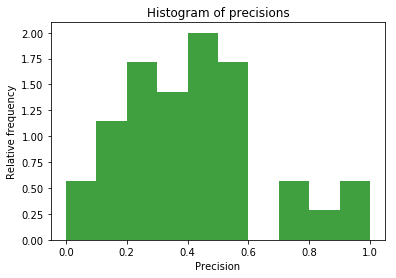

In [33]:
plot_metric(precisions, 'precision')

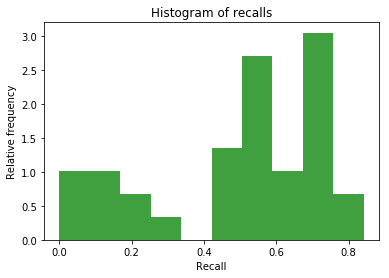

In [34]:
plot_metric(recalls, 'recall')

### 9. Export your model as a pickle file

In [35]:
filename = 'classifier.pkl'
pickle.dump(cv, open(filename, 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.